# ColabFold v1.5.5
### Customized to accept input from the iOS app via GitHub Gist.

In [17]:
#@title Mount Google Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"
print(f"Python version: {python_version}")


Mounted at /content/drive
Python version: 3.11


In [19]:
#@title Install dependencies
%%time
import os
# Define use_amber and use_templates based on inputs that will be set in the next cell
# These need default values here to avoid NameError
num_relax = 0
template_mode = "none"

use_amber = num_relax > 0
use_templates = template_mode != "none"

PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash 250814
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

# Use lowercase use_amber and use_templates as defined above
if use_amber or use_templates:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

# Use lowercase use_templates and use_amber as defined above
if use_templates and not os.path.isfile("HH_READY") and use_amber and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if use_templates and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if use_amber and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

CPU times: user 25 µs, sys: 6 µs, total: 31 µs
Wall time: 35.5 µs


In [20]:
#@title Load peptide sequence
import urllib.request
import sys

try:
    # Backend proxy URL
    sequence_url = "https://alphafold-ios.vercel.app/api/fasta"

    with urllib.request.urlopen(sequence_url) as fasta_response:
        fasta_text = fasta_response.read().decode("utf-8")

    # Parse FASTA format
    lines = fasta_text.strip().splitlines()
    sequence_lines = []
    header_found = False
    for line in lines:
        line = line.strip()
        if line.startswith(">"):
            if header_found:
                break  # Stop at second header
            header = line
            header_found = True
        else:
            sequence_lines.append(line)

    sequence = "".join(sequence_lines)

    if not sequence:
        raise ValueError("Sequence is empty.")

    print("✅ Sequence loaded successfully!")
    print(sequence)

except Exception as e:
    print("❌ Failed to load FASTA:", e)


✅ Sequence loaded successfully!
WWFSSSTSTMML


In [21]:
#@title ⚙️ Run Prediction (All-in-One, No UI)
# ------------------ User Settings ------------------
display_images = False

# Model
model_type = "alphafold2"

# MSA
msa_mode = "single_sequence"
pair_mode = "unpaired"

# Advanced settings
num_recycles = 3  # use None for 'auto'
recycle_early_stop_tolerance = 0.5  # use None for 'auto'
relax_max_iterations = 0
pairing_strategy = "greedy"
calc_extra_ptm = False

# MSA tuning
max_msa = "16:32"  # use None for 'auto'

# Sampling
num_seeds = 1
use_dropout = False

# Save settings
save_all = False
save_recycles = False
save_to_google_drive = False
dpi = 200

# Input protein sequence(s)
query_sequence = sequence  # from previous block
num_relax = 0
template_mode = "none"  # options: "none", "pdb100", "custom"

# ------------------ Conversion / Setup ------------------
num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto":
    max_msa = None
use_amber = num_relax > 0

# ------------------ Imports ------------------
import os, sys, warnings
from pathlib import Path
warnings.simplefilter("ignore", category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter("ignore", category=BiopythonDeprecationWarning)

from colabfold.download import download_alphafold_params
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
from colabfold.colabfold import plot_protein
import matplotlib.pyplot as plt
import numpy as np

# GPU warning
try:
    K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
    K80_chk = "0"
if "1" in K80_chk:
    print("WARNING: found GPU Tesla K80: limited to total length < 1000")

# Fix pdbfixer path
if use_amber and f"/usr/local/lib/python{sys.version_info.major}.{sys.version_info.minor}/site-packages/" not in sys.path:
    sys.path.insert(0,f"/usr/local/lib/python{sys.version_info.major}.{sys.version_info.minor}/site-packages/")

# ------------------ Job Setup ------------------
import re, hashlib
def add_hash(x, y): return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

jobname_base = re.sub(r'\W+', '', "".join(query_sequence[:20].split()))
jobname = add_hash(jobname_base, query_sequence)

def check(folder): return not os.path.exists(folder)
if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"
os.makedirs(jobname, exist_ok=True)

queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as f:
    f.write(f"id,sequence\n{jobname},{query_sequence}")

# Template handling
if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
elif template_mode == "custom":
    from google.colab import files
    custom_template_path = os.path.join(jobname, "template")
    os.makedirs(custom_template_path, exist_ok=True)
    uploaded = files.upload()
    for fn in uploaded.keys():
        os.rename(fn, os.path.join(custom_template_path, fn))
    use_templates = True
else:
    custom_template_path = None
    use_templates = False

# ------------------ Callbacks ------------------
def input_features_callback(input_features):
    if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

def prediction_callback(protein_obj, length, prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed and display_images:
        fig = plot_protein(protein_obj, Ls=length, dpi=150)
        plt.show()
        plt.close()

# ------------------ Run Prediction ------------------
result_dir = jobname
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)
use_cluster_profile = not ("multimer" in model_type and max_msa is not None)
download_alphafold_params(model_type, Path("."))

results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)

# ------------------ Zip Results ------------------
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")


2025-08-16 08:10:00,161 Running on GPU
2025-08-16 08:10:00,164 Found 2 citations for tools or databases
2025-08-16 08:10:00,165 Query 1/1: WWFSSSTSTMML_59e0a_0 (length 12)
2025-08-16 08:10:20,823 alphafold2_model_1_seed_000 recycle=0 pLDDT=68.2
2025-08-16 08:10:32,619 alphafold2_model_1_seed_000 recycle=1 pLDDT=73.6 tol=0.315
2025-08-16 08:10:32,619 alphafold2_model_1_seed_000 took 25.5s (1 recycles)
2025-08-16 08:10:32,754 alphafold2_model_2_seed_000 recycle=0 pLDDT=64.8
2025-08-16 08:10:32,864 alphafold2_model_2_seed_000 recycle=1 pLDDT=71.4 tol=0.264
2025-08-16 08:10:32,865 alphafold2_model_2_seed_000 took 0.2s (1 recycles)
2025-08-16 08:10:32,965 alphafold2_model_3_seed_000 recycle=0 pLDDT=71.8
2025-08-16 08:10:33,062 alphafold2_model_3_seed_000 recycle=1 pLDDT=75 tol=1.03
2025-08-16 08:10:33,160 alphafold2_model_3_seed_000 recycle=2 pLDDT=78.8 tol=0.45
2025-08-16 08:10:33,160 alphafold2_model_3_seed_000 took 0.3s (2 recycles)
2025-08-16 08:10:33,258 alphafold2_model_4_seed_000 rec

0

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

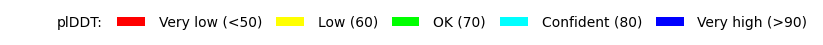

In [22]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  # ✅ view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view = py3Dmol.view(width='100%', height=500, js='https://3dmol.org/build/3Dmol.js')
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  # ✅ Adjust initial molecule view
  view.zoom(0.7)
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

# Plots and Downloads

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [ ]:
#@title Package and download results
# #@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).
# #@markdown We recommend downloading the file from a desktop browser instead of an iOS browser, since iOS may not clearly show where the file is saved.
from google.colab import files
if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  import google.colab.drive.file
  uploaded = google.colab.drive.file.DriveAPI(drive).CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

# Getting Started and Important Information<br>
<details>
<br>

**Quick start guide**
1. **Upload your single peptide sequence using PepRop.**  
* The PepRop app uploads your sequence to a GitHub Gist under the fixed filename `MYSEQUENCE.fasta`.
* The raw URL of this uploaded file is automatically tracked and updated.

2. **Open the AlphaFold Colab notebook hosted in the official GitHub repository.**  
* The notebook is configured to automatically load the latest `MYSEQUENCE.fasta` by fetching it directly from the raw URL in the Gist.

3. **Run the notebook cells to start prediction.**  
* Click the **Run button (▶️)** on each code cell to execute it individually.  
* Or go to **“Runtime” → “Run all”** to run all cells sequentially.

4. **Note:**  
* The notebook fetches the sequence directly from the fixed raw URL of `MYSEQUENCE.fasta` in the Gist, so no manual URL entry is needed.  
* You don’t need a GitHub account to run the notebook, only a Google account for Colab.  
* Uploaded sequences are **publicly accessible via the Gist raw URL**; please avoid uploading sensitive data.

**Result zip file contents**

At the end of the job a all results `jobname.result.zip` will be uploaded to your (`output_dir`) Google Drive. Each zip contains one protein.

1. PDB formatted structures sorted by avg. pIDDT. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. BibTeX file with citations for all used tools and databases.


**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or Mgnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and  [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://www.kobic.re.kr) and the [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome py3Dmol plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).

**Reference**

Easy to use AlphaFold2 protein structure [(Jumper et al. 2021)](https://www.nature.com/articles/s41586-021-03819-2) and complex [(Evans et al. 2021)](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1) prediction using multiple sequence alignments generated through MMseqs2. For details, refer to our manuscript:

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

**Modifications**

We modified the original code to accept a FASTA sequence file stored in a public GitHub Gist. This file is uploaded directly by an iOS app, allowing seamless integration between mobile input and the Colab notebook workflow. The notebook automatically retrieves the latest uploaded sequence (MYSEQUENCE.fasta) using the Gist's raw URL, eliminating the need for manual file uploads or path configuration.

**Disclaimer**

This project is not affiliated with DeepMind or the official AlphaFold project. It is a community-built tool that uses or interfaces with AlphaFold for educational or integration purposes.

<details>
